# Loading profiles from the JUMP Cell Painting Datasets  
This notebook loads a small number of plates with precomputed features and the metadata information.
## Import libraries

In [1]:
import io
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "png"  # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots


## Helper functions

In [2]:
profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)


## Load metadata

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

In [3]:
plates = pd.read_csv("metadata/plate.csv.gz")
wells = pd.read_csv("metadata/well.csv.gz")
compound = pd.read_csv("metadata/compound.csv.gz")
orf = pd.read_csv("metadata/orf.csv.gz")


## Sample plates
Let's sample two plates of a certain type (encoded in `Metadata_PlateType`) from each data-generating center (`Metadata_Source`). Note that only 9 out of the 12 sources are currently available and `source_1` does not have the plate type being queried below.

In [4]:
sample = (
    plates.query('Metadata_PlateType=="TARGET2"')
    .groupby("Metadata_Source")
    .sample(2, random_state=42)
)
sample


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
161,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2
180,source_10,2021_08_09_U2OS_48_hr_run13,Dest210727-153003,TARGET2
455,source_11,Batch5,LM71-102_1,TARGET2
343,source_11,Batch2,LM37-70_1,TARGET2
473,source_2,20210614_Batch_1,1053600674,TARGET2
599,source_2,20210808_Batch_4,1086292884,TARGET2
927,source_3,CP_33_all_Phenix1,JCPQC032,TARGET2
988,source_3,CP_36_all_Phenix1,JCPQC038,TARGET2
1188,source_4,2021_08_02_Batch10,BR00121423,TARGET2
1166,source_4,2021_07_26_Batch9,BR00121427,TARGET2


`TARGET2` plates are "sentinel" plates that are run in each batch. More on all this in future updates.

## Loading profiles
Now let's load the profiles from these plates.

Setting `columns = None` below will load all of the features.

<div class="alert alert-warning">
WARNING: Files are located in S3. This loop loads only two features per each sampled plate; loading many feature and/or many plates can take several minutes.
</div>

In [5]:
dframes = []
columns = [
    "Metadata_Source",
    "Metadata_Plate",
    "Metadata_Well",
    "Cells_AreaShape_Eccentricity",
    "Nuclei_AreaShape_Area",
]
for _, row in sample.iterrows():
    s3_path = profile_formatter.format(**row.to_dict())
    dframes.append(
        pd.read_parquet(s3_path, storage_options={"anon": True}, columns=columns)
    )
dframes = pd.concat(dframes)


Each row in `dframes` is well-level profile, containing thousands of features (n=4762) averaged over (typically) a couple of thousand cells per well.

## Join features with metadata

The profiles are annotated with only three columns of metadata (source, plate, well).

Let's add more metadata!

In [6]:
metadata = compound.merge(wells, on="Metadata_JCP2022")
ann_dframe = metadata.merge(
    dframes, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)


We now know a little bit more about each profile:

In [7]:
ann_dframe.sample(2, random_state=42)


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Eccentricity,Nuclei_AreaShape_Area
5878,JCP2022_109917,YPHMISFOHDHNIV-UHFFFAOYSA-N,InChI=1S/C15H23NO4/c1-8-3-9(2)15(20)11(4-8)12(...,source_5,ACPJUM062,K08,0.85995,716.30
5357,JCP2022_097564,WATNXVHKRRTUFK-UHFFFAOYSA-N,InChI=1S/C23H29N3O2/c1-4-8-18(9-5-2)23(27)24-1...,source_11,LM37-70_1,M06,0.74290,877.81


More metadata information will be added in the future. 

## Plot features


The scatterplot below contains every well in the sampled dataset.

In the interactive plot (see settings for `pio.renderers.default` above), you can hover over the points to see the JCP ID and the InChiKey for a given compound.

<div class="alert alert-warning">
NOTE: Because these are raw, unnormalized features, you will notice discernable clusters corresponding to each source due to batch effects.
Upcoming data releases will included normalized features, where these effects are mitigated to some extent. 
</div>

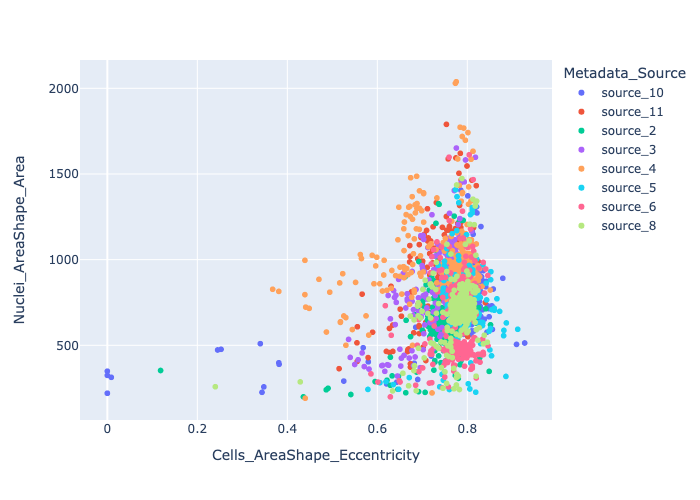

In [8]:
from pickle import FALSE, TRUE

px.scatter(
    ann_dframe,
    x="Cells_AreaShape_Eccentricity",
    y="Nuclei_AreaShape_Area",
    color="Metadata_Source",
    hover_name="Metadata_JCP2022",
    hover_data=["Metadata_InChIKey"],
)


So that's just a couple of (raw) measurements from the sentinel plates for ~66% of the sources, for the principal dataset alone. 

## Load images

[LoadData](https://cellprofiler-manual.s3.amazonaws.com/CPmanual/LoadData.html) CSV files provide Metadata associated with the images to be processed.

In [9]:
load_data = []
for _, row in sample.iterrows():
    s3_path = loaddata_formatter.format(**row.to_dict())
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
load_data = pd.concat(load_data)


Let's pick a row at random and inspect it

In [10]:
sample_loaddata = load_data.sample(1, random_state=42)
pd.melt(sample_loaddata)

,variable,value
0,Metadata_Source,source_11
1,Metadata_Batch,Batch5
2,Metadata_Plate,LM71-102_1
3,Metadata_Well,F09
4,Metadata_Site,4
5,FileName_IllumAGP,LM71-102_1_IllumAGP.npy
6,FileName_IllumDNA,LM71-102_1_IllumDNA.npy
7,FileName_IllumER,LM71-102_1_IllumER.npy
8,FileName_IllumMito,LM71-102_1_IllumMito.npy
9,FileName_IllumRNA,LM71-102_1_IllumRNA.npy


The `Metadata_` columns can be used to link the images to profiles. 
Let's pick a profile and view it's corresponding image. 

In [11]:
sample_profile = ann_dframe.sample(1, random_state=42)
sample_profile.melt()

,variable,value
0,Metadata_JCP2022,JCP2022_109917
1,Metadata_InChIKey,YPHMISFOHDHNIV-UHFFFAOYSA-N
2,Metadata_InChI,InChI=1S/C15H23NO4/c1-8-3-9(2)15(20)11(4-8)12(...
3,Metadata_Source,source_5
4,Metadata_Plate,ACPJUM062
5,Metadata_Well,K08
6,Cells_AreaShape_Eccentricity,0.85995
7,Nuclei_AreaShape_Area,716.3


First link the profile to it's images.
These are well-level profiles, and each well has typically 9 sites imaged.

In [12]:
sample_linked = pd.merge(
    load_data, sample_profile, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)
sample_linked[['Metadata_Well', 'Metadata_Site']]

,Metadata_Well,Metadata_Site
0,K08,1
1,K08,2
2,K08,3
3,K08,4
4,K08,5
5,K08,6
6,K08,7
7,K08,8
8,K08,9


Inspect details of a single site for this profile

In [13]:
sample_linked.iloc[:1].melt()

,variable,value
0,Metadata_Source,source_5
1,Metadata_Batch,JUMPCPE-20210716-Run12_20210719_162047
2,Metadata_Plate,ACPJUM062
3,Metadata_Well,K08
4,Metadata_Site,1
5,FileName_IllumAGP,ACPJUM062_IllumAGP.npy
6,FileName_IllumDNA,ACPJUM062_IllumDNA.npy
7,FileName_IllumER,ACPJUM062_IllumER.npy
8,FileName_IllumMito,ACPJUM062_IllumMito.npy
9,FileName_IllumRNA,ACPJUM062_IllumRNA.npy


Now load and display a single channel of this 5-channel image

's3://cellpainting-gallery/cpg0016-jump/source_5/images/JUMPCPE-20210716-Run12_20210719_162047/images/P01_ACPJUM062/P01_ACPJUM062_K08_T0001F001L01A01Z01C01.tif'

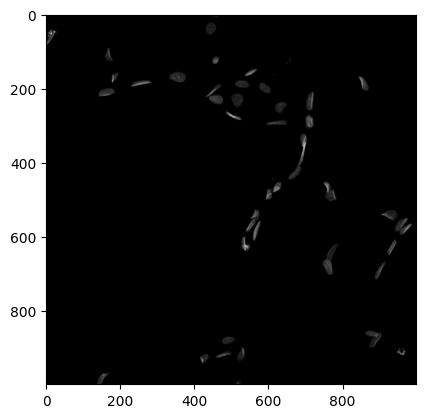

In [14]:
import os
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import boto3

image_url = os.path.join(
    sample_linked.iloc[0].PathName_OrigDNA, sample_linked.iloc[0].FileName_OrigDNA
)
s3_client = boto3.client("s3")
response = s3_client.get_object(
    Bucket=image_url.split("/")[2], Key="/".join(image_url.split("/")[3:])
)
image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")

plt.imshow(image, cmap="gray")
image_url


There's a lot more to come! We will add more example notebooks as we go.